In [18]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, optim 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import cycle
from collections import Counter
%matplotlib inline
import random
from torch.utils import data
import os
from tqdm import tqdm


In [19]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True

In [20]:
data_x=pd.read_csv("data_x_new.csv")
data_t=pd.read_csv("data_t_new.csv")
data_xx=pd.read_csv("data_x_x.csv")

In [21]:
h10_x=data_x.iloc[:, [0]]#初值x,t
h10_t=data_x.iloc[:, [1]]
h10_R=data_x.iloc[:,[2]]#初值h实部
h10_C=data_x.iloc[:,[3]]#初值h虚部
hb_x1=data_t.iloc[:,[1]]#边值-5，t
hb_t1=data_t.iloc[:,[0]]
hb_x2=data_t.iloc[:,[2]]#边值5，t
hb_t2=data_t.iloc[:,[0]]

h20_x=data_x.iloc[:, [0]]#初值x,t
h20_t=data_x.iloc[:, [1]]
h20_R=data_x.iloc[:,[4]]#初值h实部
h20_C=data_x.iloc[:,[5]]#初值h虚部

h30_x=data_xx.iloc[:, [0]]
h30_t=data_xx.iloc[:, [1]]
h30_r1=data_xx.iloc[:, [2]]
h30_c1=data_xx.iloc[:, [3]]
h30_r2=data_xx.iloc[:, [4]]
h30_c2=data_xx.iloc[:, [5]]

In [22]:
x = data_x['x']
t = data_t['t']

In [23]:
X, T = np.meshgrid(x,t)

In [24]:
hf= np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

In [25]:
hf_x=hf[:,[0]]
hf_t=hf[:,[1]]

In [26]:
train10_x,test10_x,train10_t,test10_t,train10_r,test10_r,train10_c,test10_c,trainb_x1,testb_x1,trainb_t1,testb_t1,trainb_x2,testb_x2,trainb_t2,testb_t2,train20_r,test20_r,train20_c,test20_c = train_test_split(h10_x,h10_t,h10_R,h10_C,hb_x1,hb_t1,hb_x2,hb_t2,h20_R,h20_C,test_size=0.2)

train30_x,test30_x,train30_t,test30_t,train30_r1,test30_r1,train30_c1,test30_c1,train30_r2,test30_r2,train30_c2,test30_c2=train_test_split(h30_x,h30_t,h30_r1,h30_c1,h30_r2,h30_c2)


In [27]:
trainu_x, testu_x, trainu_t, testu_t = train_test_split(hf_x, hf_t, test_size=0.2)



In [28]:
train10_x=torch.from_numpy(train10_x.to_numpy()).float()
train10_t=torch.from_numpy(train10_t.to_numpy()).float()

train10_r=torch.from_numpy(train10_r.to_numpy()).float()
train10_c=torch.from_numpy(train10_c.to_numpy()).float()

trainb_x1=torch.from_numpy(trainb_x1.to_numpy()).float()
trainb_t1=torch.from_numpy(trainb_t1.to_numpy()).float()
trainb_x2=torch.from_numpy(trainb_x2.to_numpy()).float()
trainb_t2=torch.from_numpy(trainb_t2.to_numpy()).float()

# train20_x=torch.from_numpy(train20_x.to_numpy()).float()
# train20_t=torch.from_numpy(train20_t.to_numpy()).float()
train20_r=torch.from_numpy(train20_r.to_numpy()).float()
train20_c=torch.from_numpy(train20_c.to_numpy()).float()


train30_x=torch.from_numpy(train30_x.to_numpy()).float()
train30_t=torch.from_numpy(train30_t.to_numpy()).float()
train30_r1=torch.from_numpy(train30_r1.to_numpy()).float()
train30_c1=torch.from_numpy(train30_c1.to_numpy()).float()
train30_r2=torch.from_numpy(train30_r2.to_numpy()).float()
train30_c2=torch.from_numpy(train30_c2.to_numpy()).float()

trainu_x=torch.from_numpy(trainu_x).float()
trainu_t=torch.from_numpy(trainu_t).float()

In [29]:
test10_x=torch.from_numpy(test10_x.to_numpy()).float()
test10_t=torch.from_numpy(test10_t.to_numpy()).float()
test10_r=torch.from_numpy(test10_r.to_numpy()).float()
test10_c=torch.from_numpy(test10_c.to_numpy()).float()

testb_x1=torch.from_numpy(testb_x1.to_numpy()).float()
testb_t1=torch.from_numpy(testb_t1.to_numpy()).float()
testb_x2=torch.from_numpy(testb_x2.to_numpy()).float()
testb_t2=torch.from_numpy(testb_t2.to_numpy()).float()

# test20_x=torch.from_numpy(test20_x.to_numpy()).float()
# test20_t=torch.from_numpy(test20_t.to_numpy()).float()
test20_r=torch.from_numpy(test20_r.to_numpy()).float()
test20_c=torch.from_numpy(test20_c.to_numpy()).float()

testu_x=torch.from_numpy(testu_x).float()
testu_t=torch.from_numpy(testu_t).float()

In [30]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [31]:
class DNN(torch.nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 4)
        )

    def forward(self, x):
        return self.net(x)

In [32]:
class PhysicsInformedNN():
    def __init__(self, u10_x, u10_t, u10_r, u10_c, ub_x1, ub_t1, ub_x2, ub_t2, u20_r, u20_c, uf_x, uf_t,u30_x,u30_t,u30_r1,u30_c1,u30_r2,u30_c2):
        self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
        self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
        self.u10_r = torch.tensor(u10_r, requires_grad=True).float().to(device)
        self.u10_c = torch.tensor(u10_c, requires_grad=True).float().to(device)
        
        self.ub_x1 = torch.tensor(ub_x1, requires_grad=True).float().to(device)
        self.ub_x2 = torch.tensor(ub_x2, requires_grad=True).float().to(device)
        self.ub_t1 = torch.tensor(ub_t1, requires_grad=True).float().to(device)
        self.ub_t2 = torch.tensor(ub_t2, requires_grad=True).float().to(device)
        
#         self.u20_x = u20_x.clone().detach().requires_grad_(True).float().to(device)
#         self.u20_t = torch.tensor(u20_t, requires_grad=True).float().to(device)
        self.u20_r = torch.tensor(u20_r, requires_grad=True).float().to(device)
        self.u20_c = torch.tensor(u20_c, requires_grad=True).float().to(device)
        
        self.u30_x = torch.tensor(u30_x, requires_grad=True).float().to(device)
        self.u30_t = torch.tensor(u30_t, requires_grad=True).float().to(device)
        self.u30_r1 = torch.tensor(u30_r1, requires_grad=True).float().to(device)
        self.u30_c1 = torch.tensor(u30_c1, requires_grad=True).float().to(device)
        self.u30_r2 = torch.tensor(u30_r2, requires_grad=True).float().to(device)
        self.u30_c2 = torch.tensor(u30_c2, requires_grad=True).float().to(device)
      
        
        self.uf_x = torch.tensor(uf_x,requires_grad=True).float().to(device)
        self.uf_t = torch.tensor(uf_t,requires_grad=True).float().to(device)
        
        self.lambda_1 = torch.tensor([0.9], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        
        self.lambda_2 = torch.tensor([2.3], requires_grad=True).to(device)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        self.dnn = DNN().to(device)
        self.optimizer = torch.optim.Adam([
            {'params':self.dnn.parameters()},
            {'params': [self.lambda_1], 'lr': 0.000206},
            {'params': [self.lambda_2], 'lr': 0.000106}
        ],lr=0.012 )
        
        self.iter = 0
    
        self.losshistory=[]
    def net_u(self, x, t):  
        u1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,0],1)
        v1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,1],1)
        u2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,2],1)
        v2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,3],1)
        return u1, v1, u2, v2

    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        beta=1
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        lambda_3 = -1
        lambda_4 = 0
        u1, v1,u2, v2= self.net_u(x, t)
        
        u1_t = torch.autograd.grad(
            u1, t, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_x = torch.autograd.grad(
            u1, x, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_xx = torch.autograd.grad(
            u1_x, x, 
            grad_outputs=torch.ones_like(u1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v1_t = torch.autograd.grad(
            v1, t, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_x = torch.autograd.grad(
            v1, x, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_xx = torch.autograd.grad(
            v1_x, x, 
            grad_outputs=torch.ones_like(v1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        
        u2_t = torch.autograd.grad(
            u2, t, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_x = torch.autograd.grad(
            u2, x, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_xx = torch.autograd.grad(
            u2_x, x, 
            grad_outputs=torch.ones_like(u2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v2_t = torch.autograd.grad(
            v2, t, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_x = torch.autograd.grad(
            v2, x, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_xx = torch.autograd.grad(
            v2_x, x, 
            grad_outputs=torch.ones_like(v2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f_u1 = (
            v1_t + u1_xx
        + lambda_1*u1*(u1**2 + v1**2) + lambda_2*u1*(u2**2 + v2**2) + lambda_3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + lambda_4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

        f_v1 = (
                -u1_t + v1_xx
            + lambda_1*v1*(u1**2 + v1**2) + lambda_2*v1*(u2**2 + v2**2) - lambda_3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - lambda_4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
        )

        f_u2 = (
                v2_t + beta*u2_xx
            + lambda_1*u2*(u2**2 + v2**2) + lambda_2*u2*(u1**2 + v1**2) + lambda_3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + lambda_4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
        )

        f_v2 = (
                -u2_t + beta*v2_xx
            + lambda_1*v2*(u2**2 + v2**2) + lambda_2*v2*(u1**2 + v1**2) - lambda_3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - lambda_4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
        )
        a=u1_x
        b=v1_x
        c=u2_x
        d=v2_x
        return f_u1, f_v1, f_u2, f_v2, a, b, c, d
     
    def loss_func(self):
        for self.iter in tqdm(range(12000)):
            torch.cuda.empty_cache()
            self.optimizer.zero_grad()

            u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t)
            u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
            u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_x1,self.ub_t1)
            u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_x2,self.ub_t2)
            
            
            a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_x1,self.ub_t1)
            a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_x2,self.ub_t2)
            
            f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
            
            loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
            loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
            loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
            loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
            loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
            
            loss = 3*loss_f+loss_u0 + loss_ub + loss_ubx+loss_u1
            
            loss.backward()
            self.optimizer.step()
            
            self.losshistory.append(loss.clone().detach().cpu())
            
            self.iter += 1
            with torch.no_grad():
                if self.iter % 500 == 0:
                    print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e, Loss_u1: %.5e, lambda1: %.5e, lambda2: %.5e' % (self.iter, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item(), loss_u1.item(), self.lambda_1,self.lambda_2))
        return float(loss)
        
 
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        
    def predict1(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        u1, v1 , u2, v2= self.net_u(x, t)
        u1 = u1.detach().cpu().numpy()
        v1 = v1.detach().cpu().numpy()
        u2 = u2.detach().cpu().numpy()
        v2 = v2.detach().cpu().numpy()
        return u1, v1, u2, v2
    
    def predict2(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        f1, f2, f3, f4, a, b, c, d = self.net_f(x, t)
        f1 = f1.detach().cpu().numpy()
        f2 = f2.detach().cpu().numpy()
        f3 = f3.detach().cpu().numpy()
        f4 = f4.detach().cpu().numpy()
        return  f1, f2, f3, f4, a, b, c, d

In [33]:


model = PhysicsInformedNN(train10_x, train10_t, train10_r, train10_c, 
                          trainb_x1, trainb_t1, trainb_x2, trainb_t2,
                        train20_r, train20_c, trainu_x, trainu_t,
                         train30_x,train30_t, train30_r1, train30_c1,train30_r2,train30_c2)




C:\Users\npofsi\AppData\Local\Temp\ipykernel_28092\2187313917.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_28092\2187313917.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_28092\2187313917.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_r = torch.tensor(u10_r, requires_grad=True).float

In [34]:
%%time
model.losshistory=[]            
model.train()

  4%|▍         | 501/12000 [01:09<26:16,  7.29it/s]

Iter 500, Loss: 3.06851e-01, Loss_u0: 2.86183e-02, Loss_ub: 6.36243e-05, Loss_ubx: 6.05416e-05, Loss_f: 1.73875e-02, Loss_u1: 2.25946e-01, lambda1: 9.73275e-01, lambda2: 2.31893e+00


  8%|▊         | 1001/12000 [02:18<24:16,  7.55it/s]

Iter 1000, Loss: 2.28110e-01, Loss_u0: 4.56717e-03, Loss_ub: 1.66180e-04, Loss_ubx: 7.37655e-05, Loss_f: 3.07496e-02, Loss_u1: 1.31054e-01, lambda1: 9.84710e-01, lambda2: 2.32176e+00


 13%|█▎        | 1501/12000 [03:26<22:31,  7.77it/s]

Iter 1500, Loss: 1.19704e-01, Loss_u0: 4.18112e-03, Loss_ub: 4.60063e-05, Loss_ubx: 2.79326e-05, Loss_f: 8.69157e-03, Loss_u1: 8.93745e-02, lambda1: 9.82508e-01, lambda2: 2.32681e+00


 17%|█▋        | 2001/12000 [04:31<21:32,  7.73it/s]

Iter 2000, Loss: 1.01402e-01, Loss_u0: 3.99123e-03, Loss_ub: 4.17465e-05, Loss_ubx: 3.65926e-05, Loss_f: 4.97725e-03, Loss_u1: 8.24004e-02, lambda1: 9.77867e-01, lambda2: 2.32625e+00


 21%|██        | 2501/12000 [05:36<20:03,  7.89it/s]

Iter 2500, Loss: 9.82378e-02, Loss_u0: 3.18354e-03, Loss_ub: 3.57637e-05, Loss_ubx: 3.23628e-05, Loss_f: 8.83991e-03, Loss_u1: 6.84663e-02, lambda1: 9.70837e-01, lambda2: 2.32428e+00


 25%|██▌       | 3001/12000 [06:41<19:41,  7.62it/s]

Iter 3000, Loss: 8.17291e-02, Loss_u0: 3.22700e-03, Loss_ub: 4.07716e-05, Loss_ubx: 8.39939e-06, Loss_f: 4.69595e-03, Loss_u1: 6.43651e-02, lambda1: 9.63928e-01, lambda2: 2.32118e+00


 29%|██▉       | 3501/12000 [07:48<18:31,  7.64it/s]

Iter 3500, Loss: 7.95852e-02, Loss_u0: 3.11327e-03, Loss_ub: 3.83270e-05, Loss_ubx: 1.21348e-05, Loss_f: 5.38334e-03, Loss_u1: 6.02715e-02, lambda1: 9.57562e-01, lambda2: 2.31780e+00


 33%|███▎      | 4001/12000 [08:54<17:33,  7.60it/s]

Iter 4000, Loss: 1.05867e-01, Loss_u0: 3.29455e-03, Loss_ub: 5.83900e-05, Loss_ubx: 1.74173e-05, Loss_f: 1.40656e-02, Loss_u1: 6.02996e-02, lambda1: 9.51503e-01, lambda2: 2.31450e+00


 38%|███▊      | 4501/12000 [09:59<16:07,  7.75it/s]

Iter 4500, Loss: 1.11581e-01, Loss_u0: 3.83109e-03, Loss_ub: 2.42801e-05, Loss_ubx: 3.55985e-05, Loss_f: 7.29598e-03, Loss_u1: 8.58024e-02, lambda1: 9.52934e-01, lambda2: 2.31795e+00


 42%|████▏     | 5001/12000 [11:04<14:37,  7.98it/s]

Iter 5000, Loss: 9.80838e-02, Loss_u0: 3.38106e-03, Loss_ub: 1.42240e-05, Loss_ubx: 1.91875e-05, Loss_f: 5.88040e-03, Loss_u1: 7.70281e-02, lambda1: 9.46610e-01, lambda2: 2.31605e+00


 46%|████▌     | 5501/12000 [12:10<14:31,  7.46it/s]

Iter 5500, Loss: 9.27589e-02, Loss_u0: 2.66606e-03, Loss_ub: 2.04202e-04, Loss_ubx: 1.09868e-04, Loss_f: 5.99253e-03, Loss_u1: 7.18012e-02, lambda1: 9.40055e-01, lambda2: 2.31363e+00


 50%|█████     | 6001/12000 [13:16<13:26,  7.44it/s]

Iter 6000, Loss: 8.01112e-02, Loss_u0: 2.84054e-03, Loss_ub: 3.36380e-05, Loss_ubx: 2.96763e-05, Loss_f: 4.94401e-03, Loss_u1: 6.23753e-02, lambda1: 9.33872e-01, lambda2: 2.31097e+00


 54%|█████▍    | 6501/12000 [14:22<14:24,  6.36it/s]

Iter 6500, Loss: 8.41444e-02, Loss_u0: 2.47060e-03, Loss_ub: 2.19961e-05, Loss_ubx: 2.76201e-05, Loss_f: 5.94198e-03, Loss_u1: 6.37982e-02, lambda1: 9.27562e-01, lambda2: 2.30810e+00


 58%|█████▊    | 7001/12000 [15:29<11:10,  7.45it/s]

Iter 7000, Loss: 1.61442e-01, Loss_u0: 5.89477e-03, Loss_ub: 1.97943e-05, Loss_ubx: 4.18574e-06, Loss_f: 9.30938e-03, Loss_u1: 1.27595e-01, lambda1: 9.39548e-01, lambda2: 2.31485e+00


 63%|██████▎   | 7501/12000 [16:34<10:01,  7.48it/s]

Iter 7500, Loss: 1.22149e-01, Loss_u0: 3.91647e-03, Loss_ub: 4.40915e-05, Loss_ubx: 2.21850e-05, Loss_f: 7.75565e-03, Loss_u1: 9.48998e-02, lambda1: 9.40365e-01, lambda2: 2.31803e+00


 67%|██████▋   | 8001/12000 [17:39<08:42,  7.66it/s]

Iter 8000, Loss: 1.12056e-01, Loss_u0: 3.26908e-03, Loss_ub: 6.49944e-05, Loss_ubx: 2.27629e-05, Loss_f: 7.76403e-03, Loss_u1: 8.54075e-02, lambda1: 9.36338e-01, lambda2: 2.31883e+00


 71%|███████   | 8501/12000 [18:44<08:05,  7.21it/s]

Iter 8500, Loss: 1.02927e-01, Loss_u0: 3.13068e-03, Loss_ub: 6.44515e-05, Loss_ubx: 2.26361e-05, Loss_f: 6.10490e-03, Loss_u1: 8.13949e-02, lambda1: 9.32036e-01, lambda2: 2.31859e+00


 75%|███████▌  | 9001/12000 [19:48<06:32,  7.64it/s]

Iter 9000, Loss: 9.85718e-02, Loss_u0: 3.23522e-03, Loss_ub: 5.74748e-05, Loss_ubx: 1.46972e-05, Loss_f: 5.41635e-03, Loss_u1: 7.90153e-02, lambda1: 9.27704e-01, lambda2: 2.31786e+00


 79%|███████▉  | 9501/12000 [20:52<05:19,  7.82it/s]

Iter 9500, Loss: 9.31129e-02, Loss_u0: 2.62291e-03, Loss_ub: 4.10918e-05, Loss_ubx: 9.55641e-06, Loss_f: 5.45401e-03, Loss_u1: 7.40773e-02, lambda1: 9.23764e-01, lambda2: 2.31688e+00


 83%|████████▎ | 10001/12000 [21:57<04:20,  7.66it/s]

Iter 10000, Loss: 9.74663e-02, Loss_u0: 3.06993e-03, Loss_ub: 3.77362e-05, Loss_ubx: 8.43513e-06, Loss_f: 6.56570e-03, Loss_u1: 7.46531e-02, lambda1: 9.19726e-01, lambda2: 2.31574e+00


 88%|████████▊ | 10501/12000 [23:01<03:15,  7.68it/s]

Iter 10500, Loss: 9.69863e-02, Loss_u0: 2.47296e-03, Loss_ub: 2.90525e-05, Loss_ubx: 9.56871e-06, Loss_f: 7.72673e-03, Loss_u1: 7.12945e-02, lambda1: 9.15420e-01, lambda2: 2.31441e+00


 92%|█████████▏| 11001/12000 [24:07<02:15,  7.36it/s]

Iter 11000, Loss: 8.39722e-02, Loss_u0: 2.43516e-03, Loss_ub: 3.31170e-05, Loss_ubx: 7.35459e-06, Loss_f: 5.18441e-03, Loss_u1: 6.59433e-02, lambda1: 9.11417e-01, lambda2: 2.31297e+00


 96%|█████████▌| 11501/12000 [25:13<01:09,  7.17it/s]

Iter 11500, Loss: 8.31560e-02, Loss_u0: 2.27626e-03, Loss_ub: 3.29350e-05, Loss_ubx: 8.26985e-06, Loss_f: 5.91330e-03, Loss_u1: 6.30986e-02, lambda1: 9.06864e-01, lambda2: 2.31097e+00


100%|██████████| 12000/12000 [26:18<00:00,  7.60it/s]

Iter 12000, Loss: 1.43741e+00, Loss_u0: 3.08471e-01, Loss_ub: 5.45040e-04, Loss_ubx: 1.68097e-04, Loss_f: 2.20100e-01, Loss_u1: 4.67923e-01, lambda1: 8.98635e-01, lambda2: 2.30698e+00
Wall time: 26min 18s


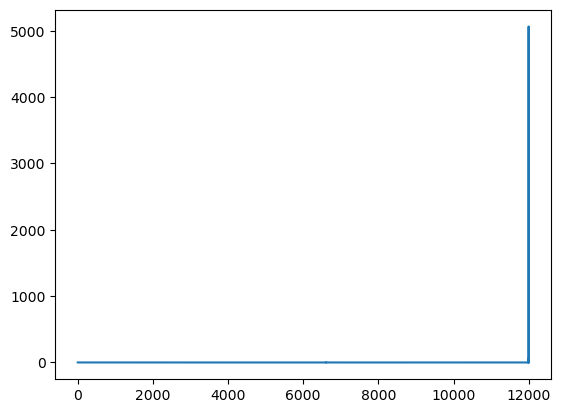

In [35]:
plt.plot(model.losshistory)

In [36]:
u00_1, v00_1, u00_2, v00_2 = model.predict1(test10_x,test10_t)
u11_1, v11_1, u11_2, v11_2 = model.predict1(testb_x1,testb_t1)
u22_1, v22_1, u22_2, v22_2 = model.predict1(testb_x2,testb_t2)
a1,b1,c1,d1, ux11_1, vx11_1, ux11_2, vx11_2 = model.predict2(testb_x1,testb_t1)
a1,b1,c1,d1, ux22_1, vx22_1, ux22_2, vx22_2 = model.predict2(testb_x2,testb_t2)

f1, f2, f3, f4,a1,b1,c1,d1 = model.predict2(testu_x,testu_t)     

C:\Users\npofsi\AppData\Local\Temp\ipykernel_28092\2187313917.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_28092\2187313917.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(Y, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_28092\2187313917.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\App

In [37]:
error_u0= ((np.linalg.norm(test10_r - u00_1, 2))**2+(np.linalg.norm(test10_c - v00_1, 2))**2+(np.linalg.norm(test20_r - u00_2, 2))**2+(np.linalg.norm(test20_c - v00_2, 2))**2)/20
error_ub= ((np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2+(np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2)/20
error_ubx= (
    (np.linalg.norm(ux11_1.cpu().detach().numpy() - ux22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_1.cpu().detach().numpy() - vx22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(ux11_2.cpu().detach().numpy() - ux22_2.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_2.cpu().detach().numpy() - vx22_2.cpu().detach().numpy(), 2))**2)/20

error_f= ((np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2+(np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2)/2000
print('Error_u0: %.5e, Error_ub: %.5e, Error_ubx: %.5e, Error_f: %.5e' % (error_u0.item(), error_ub.item(), error_ubx.item(), error_f.item()))




Error_u0: 2.88422e-01, Error_ub: 2.42360e+00, Error_ubx: 6.23008e-02, Error_f: 4.45312e+01
